### Packages

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfl
import pandas as pd

%matplotlib inline

### Load data and split into train/test sets

In [2]:
def load_signs_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # test set labels

    classes = np.array(test_dataset["list_classes"][:]) # list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [4]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_signs_dataset()

X_train = X_train_orig/255.
X_test = X_test_orig/255.

Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


y = 5


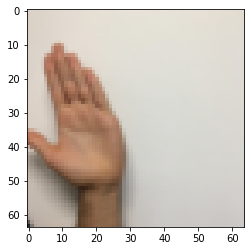

In [5]:
# Example of an image from the dataset
index = 300
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

### TF Keras Functional API

In [6]:
def convolutional_model(input_shape):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    We'll hard-code some values
    such as the stride and kernel (filter) sizes. 
    Normally, functions should take these values as function parameters.
    
    Arguments:
    input_img -- input dataset, of shape (input_shape)

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """

    input_img = tf.keras.Input(shape=input_shape)
    ## CONV2D: 8 filters 4x4, stride of 1, padding 'SAME'
    ## RELU
    ## MAXPOOL: window 8x8, stride 8, padding 'SAME'
    ## CONV2D: 16 filters 2x2, stride 1, padding 'SAME'
    ## RELU
    ## MAXPOOL: window 4x4, stride 4, padding 'SAME'
    ## FLATTEN
    ## Dense layer
    ## 6 neurons in output layer 
    # outputs

    Z1 = tfl.Conv2D(filters = 8,kernel_size = 4,strides=(1,1),padding='same')(input_img)
    A1 = tfl.ReLU()(Z1)
    P1 = tfl.MaxPool2D(pool_size=(8, 8), strides=(8, 8), padding='same')(A1)
    Z2 = tfl.Conv2D(filters = 16,kernel_size = 2,strides=(1,1),padding='same')(P1)
    A2 = tfl.ReLU()(Z2)
    P2 = tfl.MaxPool2D(pool_size=(4, 4), strides=(4, 4), padding='same')(A2)
    F = tfl.Flatten()(P2)
    outputs = tfl.Dense(units=6, activation='softmax')(F)
    
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [7]:
conv_model = convolutional_model((64, 64, 3))
conv_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [8]:
conv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 8)         392       
                                                                 
 re_lu (ReLU)                (None, 64, 64, 8)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 8)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          528       
                                                                 
 re_lu_1 (ReLU)              (None, 8, 8, 16)          0         
                                                             

### Train the Model

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)
history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
17/17 [==============================] - 1s 43ms/step - loss: 1.7875 - accuracy: 0.2046 - val_loss: 1.7837 - val_accuracy: 0.1833
Epoch 2/100
17/17 [==============================] - 1s 34ms/step - loss: 1.7743 - accuracy: 0.2389 - val_loss: 1.7762 - val_accuracy: 0.2417
Epoch 3/100
17/17 [==============================] - 1s 37ms/step - loss: 1.7644 - accuracy: 0.3000 - val_loss: 1.7672 - val_accuracy: 0.2583
Epoch 4/100
17/17 [==============================] - 1s 34ms/step - loss: 1.7546 - accuracy: 0.3481 - val_loss: 1.7585 - val_accuracy: 0.2750
Epoch 5/100
17/17 [==============================] - 1s 33ms/step - loss: 1.7417 - accuracy: 0.4019 - val_loss: 1.7471 - val_accuracy: 0.3750
Epoch 6/100
17/17 [==============================] - 1s 37ms/step - loss: 1.7276 - accuracy: 0.4176 - val_loss: 1.7339 - val_accuracy: 0.3667
Epoch 7/100
17/17 [==============================] - 1s 37ms/step - loss: 1.7092 - accuracy: 0.4343 - val_loss: 1.7179 - val_accuracy: 0.4083
Epoch 

17/17 [==============================] - 1s 34ms/step - loss: 0.7416 - accuracy: 0.7667 - val_loss: 0.7931 - val_accuracy: 0.7000
Epoch 59/100
17/17 [==============================] - 1s 35ms/step - loss: 0.7347 - accuracy: 0.7694 - val_loss: 0.7874 - val_accuracy: 0.7000
Epoch 60/100
17/17 [==============================] - 1s 35ms/step - loss: 0.7281 - accuracy: 0.7713 - val_loss: 0.7818 - val_accuracy: 0.7333
Epoch 61/100
17/17 [==============================] - 1s 31ms/step - loss: 0.7214 - accuracy: 0.7731 - val_loss: 0.7762 - val_accuracy: 0.7333
Epoch 62/100
17/17 [==============================] - 1s 34ms/step - loss: 0.7151 - accuracy: 0.7741 - val_loss: 0.7711 - val_accuracy: 0.7333
Epoch 63/100
17/17 [==============================] - 1s 33ms/step - loss: 0.7089 - accuracy: 0.7750 - val_loss: 0.7661 - val_accuracy: 0.7333
Epoch 64/100
17/17 [==============================] - 1s 34ms/step - loss: 0.7026 - accuracy: 0.7769 - val_loss: 0.7613 - val_accuracy: 0.7333
Epoch 65/100

<a name='5'></a>
###  History Object 

The history object is an output of the `.fit()` operation, and provides a record of all the loss and metric values in memory. It's stored as a dictionary that we can retrieve at `history.history`: 

In [10]:
history.history

{'loss': [1.7875032424926758,
  1.7743139266967773,
  1.764415979385376,
  1.7545901536941528,
  1.7416516542434692,
  1.727608561515808,
  1.7091525793075562,
  1.68633234500885,
  1.6579196453094482,
  1.6264625787734985,
  1.5903167724609375,
  1.550455927848816,
  1.5083016157150269,
  1.4642149209976196,
  1.4207401275634766,
  1.3788580894470215,
  1.3412822484970093,
  1.3065803050994873,
  1.2697786092758179,
  1.2442045211791992,
  1.214585542678833,
  1.1907763481140137,
  1.166070580482483,
  1.1428821086883545,
  1.1228927373886108,
  1.103293538093567,
  1.0845311880111694,
  1.0662678480148315,
  1.047858476638794,
  1.0315889120101929,
  1.017897129058838,
  1.001220941543579,
  0.9863975048065186,
  0.9726288914680481,
  0.9603601694107056,
  0.9465247988700867,
  0.933837354183197,
  0.9220975637435913,
  0.9107961654663086,
  0.8995155096054077,
  0.8884658813476562,
  0.8780140280723572,
  0.8677221536636353,
  0.8577911853790283,
  0.8477495312690735,
  0.8383928537

### Plotting epoch, loss and accuracy

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

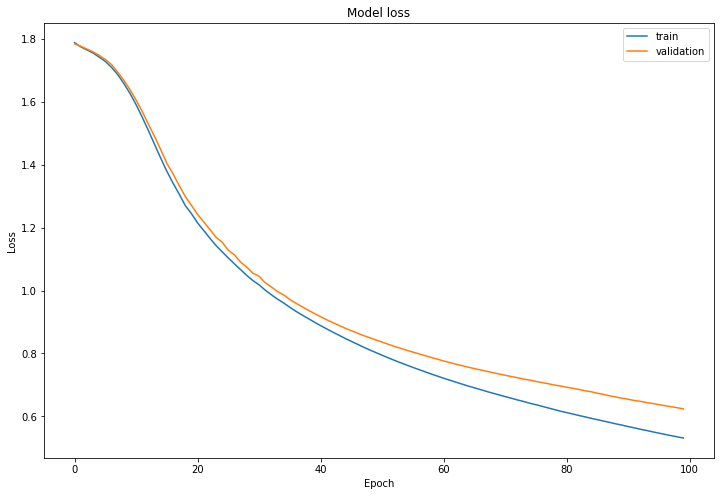

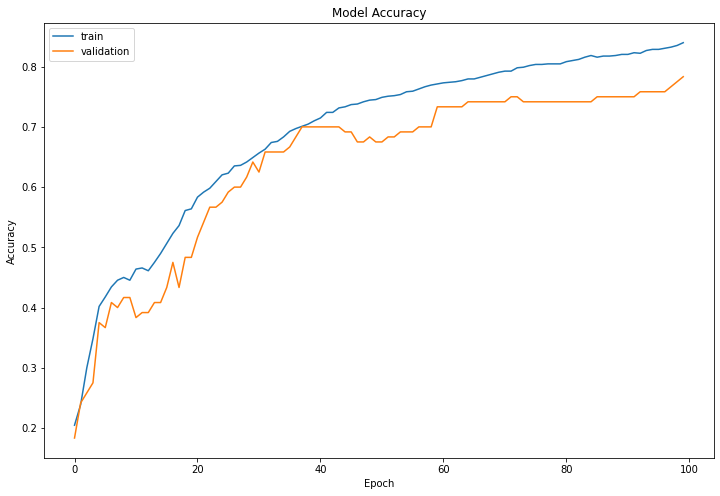

In [11]:
pd.options.mode.chained_assignment = None  # default='warn'
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')